# Определение стоимости автомобилей

Заказчик - сервис по продаже б/у автомобилей. Заказчик разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. 

Данные: технические характеристики, комплектации и цены автомобилей. 

**Задача**: построить модель для определения стоимости (важны качество и скорость предсказаний, время обучения)

## Изучение данных

In [2]:
# загружаю необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# загружаю данные 
data = pd.read_csv('/datasets/autos.csv')
display(data)

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
0           0         golf     150000                  0    petrol   
1         190          NaN     125000                  5  gasoline   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
...       ...          ...        ...                ...       ...   
354364      0         colt     150000                  7    petrol   
354365      0          NaN      20000                  1       NaN   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

                 Brand NotRepaired          DateCreated  NumberOfPictures  \
0           volkswagen         NaN  2016-03-24 00:00:00                 0   
1                 audi         yes  2016-03-24 00:00:00                 0   
2                 jeep         NaN  2016-03-14 00:00:00                 0   
3           volkswagen          no  2016-03-17 00:00:00                 0   
4                skoda          no  2016-03-31 00:00:00                 0   
...                ...         ...                  ...               ...   
354364      mitsubishi         yes  2016-03-21 00:00:00                 0   
354365  sonstige_autos         NaN  2016-03-14 00:00:00                 0   
354366           smart          no  2016-03-05 00:00:00                 0   
354367      volkswagen          no  2016-03-19 00:00:00                 0   
354368      volkswagen         NaN  2016-03-20 00:00:00                 0   

        PostalCode             LastSeen  
0            70435  2016-04-07 03:16:57  
1            66954  2016-04-07 01:46:50  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
...            ...                  ...  
354364        2694  2016-03-21 10:42:49  
354365       39576  2016-04-06 00:46:52  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[354369 rows x 16 columns]

## Обработка данных

In [3]:
print(data.shape)

(354369, 16)


In [4]:
print(data.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')


**Признаки** 

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
**Целевой признак**
    
    Price — цена (евро)

In [5]:
data.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [6]:
# проверяю датасет на наличие дубликатов
print(data.duplicated().sum())

4


In [7]:
# удалаяю дубликаты
data = data.drop_duplicates()
print(data.shape)

(354365, 16)


In [8]:
# проверяю на наличие пропусков 
print(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [9]:
# устраняю пропуски 
print('уникальные значения типа автомобильного кузова')
print(data['VehicleType'].unique())
print()
print('уникальные значения типа коробки передач')
print(data['Gearbox'].unique())
print()
print('уникальные значения модели автомобиля')
print(data['Model'].unique())
print()
print('уникальные значения типа топлива')
print(data['FuelType'].unique())
print()
print('уникальные значения ремонта')
print(data['NotRepaired'].unique())
print()
print('уникальные значения брендов')
print(data['Brand'].unique())
print()
print('уникальные значения количества фотографий')
print(data['NumberOfPictures'].unique())

уникальные значения типа автомобильного кузова
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

уникальные значения типа коробки передач
['manual' 'auto' nan]

уникальные значения модели автомобиля
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia'

In [10]:
# заменяю пропуски в категориальных признаках на 'unknown'
# к категориальным признакам относятся 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'
data.loc[data['VehicleType'].isna(), 'VehicleType'] = 'unknown'
data.loc[data['Gearbox'].isna(), 'Gearbox'] = 'unknown'
data.loc[data['Model'].isna(), 'Model'] = 'unknown'
data.loc[data['FuelType'].isna(), 'FuelType'] = 'unknown'
data.loc[data['NotRepaired'].isna(), 'NotRepaired'] = 'unknown'
print(data.isna().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [11]:
# в количественных признаках пропусков нет, следовательно, остально только изменить типы данных
# меняю тип данных в столбцах с датой и временем

data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
print(data.dtypes)

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen                     object
dtype: object


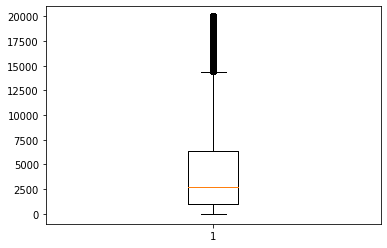

Среднее значение цены составляет 4416.679830118663
Медианное значение цены составляет 2700.0
Количество объявлений, цена которых превышает 15000 евро 14881
Это составляет 4.19934248585498 % данных


In [12]:
# рассматриваю данные на особые аномалии
# столбец Price
plt.boxplot(data['Price'])
plt.show()
print('Среднее значение цены составляет', data['Price'].mean())
print('Медианное значение цены составляет', data['Price'].median())
print('Количество объявлений, цена которых превышает 15000 евро', data[data['Price']>15000]['Price'].count())
print('Это составляет', data[data['Price']>15000]['Price'].count() / data['Price'].count() * 100, '% данных')

In [13]:
# так как аномально высокая цена составляет всего 4% данных, следовательно, могу их удалить
data = data[~(data['Price']>15000)]
print(data.shape)

(339484, 16)


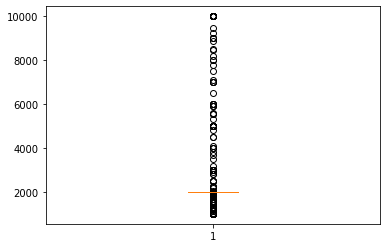

Количество объявлений, год которых меньше 1950 и превышает 2022 равно 347


In [14]:
# рассматриваю данные на особые аномалии
# столбец RegistrationYear
plt.boxplot(data['RegistrationYear'])
plt.show()

print('Количество объявлений, год которых меньше 1950 и превышает 2022 равно' , data[(data['RegistrationYear']>=2022) | (data['RegistrationYear']<=1950)]['RegistrationYear'].count())

In [15]:
# так как год выпуска не может превышать 2022 год и таких строк всего 102, сдедовательно, удаляю эти строки
data = data[~((data['RegistrationYear']>=2022) | (data['RegistrationYear']<=1950))]
print(data.shape)

(339137, 16)


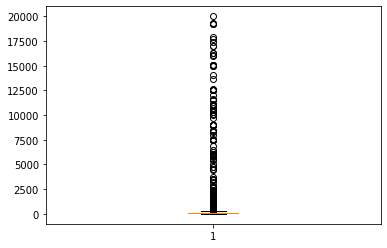

Среднее значение лошадиных сил составляет 106.9960576404226
Медианное значение лошадиных сил составляет 102.0
Количество объявлений, количество лошадиных сил автомобиля которых превышает 300 л.с. равно 2575
Это составляет 0.7592801729094731 % данных


In [16]:
# рассматриваю данные на особые аномалии
# столбец Power
plt.boxplot(data['Power'])
plt.show()
# значение лошадиных сил в среднем не превышает 200 на обычных машинах
print('Среднее значение лошадиных сил составляет', data['Power'].mean())
print('Медианное значение лошадиных сил составляет', data['Power'].median())
print('Количество объявлений, количество лошадиных сил автомобиля которых превышает 300 л.с. равно' , data[(data['Power']>300)|(data['Power']<0)]['Power'].count())
print('Это составляет', data[data['Power']>300]['Power'].count() / data['Power'].count() * 100, '% данных')

In [17]:
# так как мощность поддержанных автомобилей вряд ли может  быть меньше либо равно нулю превышать 300, 
# а также такие данные составляют всего 0,76% датасета
# следовательно, удаляю эти данные 
data = data[(data['Power']<=300)&(data['Power']>0)]
print(data.shape)

(297029, 16)


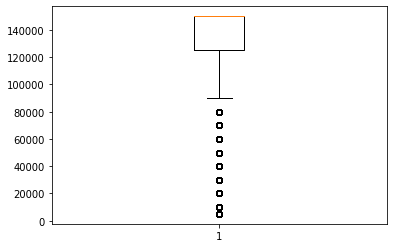

Среднее значение лошадиных сил составляет 130254.62160260446
Медианное значение лошадиных сил составляет 150000.0
Количество объявлений, пробег которых меньше 80 тыс. км равно 3861
Это составляет 1.2998730763662807 % данных


In [18]:
# рассматриваю данные на особые аномалии
# столбец Kilometer
plt.boxplot(data['Kilometer'])
plt.show()
# пробег на поддержанном автомобиле менее 20000 км выглядит подозрительно
print('Среднее значение лошадиных сил составляет', data['Kilometer'].mean())
print('Медианное значение лошадиных сил составляет', data['Kilometer'].median())
print('Количество объявлений, пробег которых меньше 80 тыс. км равно' ,data[data['Kilometer']<20000]['Kilometer'].count())
print('Это составляет', data[data['Kilometer']<20000]['Power'].count() / data['Kilometer'].count() * 100, '% данных')

In [19]:
# пробег на поддержанном автомобиле менее 20000 км выглядит подозрительно
# следовательно, удаляю эти данные 
data = data[data['Kilometer']>20000]
print(data.shape)

(290445, 16)


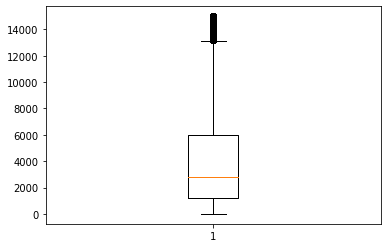

Среднее значение цены составляет 4023.3999931140147
Медианное значение цены составляет 2799.0
Количество объявлений, цена которых больше 13000 евро и меньше 500 евро, равно 14947
Это составляет 4.499302793988535 % данных


In [20]:
# рассматриваю аномалии в цене
# столбец Price
plt.boxplot(data['Price'])
plt.show()

# цена автомоиля выше 13000 евро сильно завышена, а все что ниже 500 евро - слишком мало, проверяю их количество 
print('Среднее значение цены составляет', data['Price'].mean())
print('Медианное значение цены составляет', data['Price'].median())
print('Количество объявлений, цена которых больше 13000 евро и меньше 500 евро, равно' ,data[(data['Price']>13000)|(data['Price']==0)]['Kilometer'].count())
print('Это составляет', data[(data['Price']>13000)|(data['Price']==500)]['Price'].count() / data['Price'].count() * 100, '% данных')

In [21]:
# цена автомоиля выше 13000 евро сильно завышена, а все что ниже 500 евро - слишком мало, проверяю их количество 
# следовательно, удаляю эти данные 
data = data[(data['Price']<13000)&(data['Price']!=0)]
print(data.shape)

(274991, 16)


## Обучение моделей

Столбцы с датами, почтовым индексом, количеством фотографий и месяцем регистрации автомобиля  никак не будут влиять на цену автомобиля, поэтому их можно не включать в признаки. 

In [22]:
display(data)

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
2      2016-03-14 12:52:21   9800          suv              2004    auto   
3      2016-03-17 16:54:04   1500        small              2001  manual   
4      2016-03-31 17:25:20   3600        small              2008  manual   
5      2016-04-04 17:36:23    650        sedan              1995  manual   
6      2016-04-01 20:48:51   2200  convertible              2004  manual   
...                    ...    ...          ...               ...     ...   
354361 2016-03-09 13:37:43   5250      unknown              2016    auto   
354362 2016-03-19 19:53:49   3200        sedan              2004  manual   
354366 2016-03-05 19:56:21   1199  convertible              2000    auto   
354367 2016-03-19 18:57:12   9200          bus              1996  manual   
354368 2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
5         102          3er     150000                 10    petrol   
6         109      2_reihe     150000                  8    petrol   
...       ...          ...        ...                ...       ...   
354361    150          159     150000                 12   unknown   
354362    225         leon     150000                  5    petrol   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

             Brand NotRepaired DateCreated  NumberOfPictures  PostalCode  \
2             jeep     unknown  2016-03-14                 0       90480   
3       volkswagen          no  2016-03-17                 0       91074   
4            skoda          no  2016-03-31                 0       60437   
5              bmw         yes  2016-04-04                 0       33775   
6          peugeot          no  2016-04-01                 0       67112   
...            ...         ...         ...               ...         ...   
354361  alfa_romeo          no  2016-03-09                 0       51371   
354362        seat         yes  2016-03-19                 0       96465   
354366       smart          no  2016-03-05                 0       26135   
354367  volkswagen          no  2016-03-19                 0       87439   
354368  volkswagen     unknown  2016-03-20                 0       40764   

                   LastSeen  
2       2016-04-05 12:47:46  
3       2016-03-17 17:40:17  
4       2016-04-06 10:17:21  
5       2016-04-06 19:17:07  
6       2016-04-05 18:18:39  
...                     ...  
354361  2016-03-13 01:44:13  
354362  2016-03-19 20:44:43  
354366  2016-03-11 18:17:12  
354367  2016-04-07 07:15:26  
354368  2016-03-24 12:45:21  

[274991 rows x 16 columns]

In [23]:
# сначала удаляю из таблицы столбцы, которые никак не влияют на цену автомобиля 
# и они буду бесполезны для работы модели
data = data.drop(['DateCrawled', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
print(data.shape)
print(data.columns)
print(data.isna().sum())

(274991, 10)
Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')
Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64


In [24]:
# кодирую категориальные признаки и преобразовываю их в числа с помощью Ordinal Encoding
coded_features = data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

encoder = OrdinalEncoder()
encoder.fit(coded_features)
oe_coded_features = pd.DataFrame(encoder.transform(coded_features), columns=coded_features.columns)
display(oe_coded_features)
print(oe_coded_features.isna().sum())

VehicleType  Gearbox  Model  FuelType  Brand  NotRepaired
0               6.0      0.0  116.0       2.0   14.0          1.0
1               5.0      1.0  115.0       6.0   38.0          0.0
2               5.0      1.0  101.0       2.0   31.0          0.0
3               4.0      1.0   11.0       6.0    2.0          2.0
4               1.0      1.0    8.0       6.0   25.0          0.0
...             ...      ...    ...       ...    ...          ...
274986          7.0      0.0    4.0       7.0    0.0          0.0
274987          4.0      1.0  139.0       6.0   30.0          2.0
274988          1.0      0.0  106.0       6.0   32.0          0.0
274989          0.0      1.0  222.0       2.0   38.0          0.0
274990          8.0      1.0  115.0       2.0   38.0          1.0

[274991 rows x 6 columns]

VehicleType    0
Gearbox        0
Model          0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64


In [25]:
# # собираю теперь все признаки в одну таблицу 
data_uncoded = data.drop(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], axis=1)
print(data_uncoded.columns)
print(data_uncoded.shape)
print(oe_coded_features.shape)
# print(data_coded.isna().sum())

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer'], dtype='object')
(274991, 4)
(274991, 6)


In [26]:
data_coded =  oe_coded_features.join(data_uncoded, how='right')
print(data_coded.isna().sum())

VehicleType         61648
Gearbox             61648
Model               61648
FuelType            61648
Brand               61648
NotRepaired         61648
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
dtype: int64


In [27]:
data_coded = data_coded.dropna()
print(data_coded.shape)

(213343, 10)


In [28]:
data_coded.dtypes

VehicleType         float64
Gearbox             float64
Model               float64
FuelType            float64
Brand               float64
NotRepaired         float64
Price                 int64
RegistrationYear      int64
Power                 int64
Kilometer             int64
dtype: object

In [29]:
data_coded['Price'] = data_coded['Price'].astype('float')
data_coded['RegistrationYear'] = data_coded['RegistrationYear'].astype('float')
data_coded['Power'] = data_coded['Power'].astype('float')
data_coded['Kilometer'] = data_coded['Kilometer'].astype('float')
data_coded.dtypes

VehicleType         float64
Gearbox             float64
Model               float64
FuelType            float64
Brand               float64
NotRepaired         float64
Price               float64
RegistrationYear    float64
Power               float64
Kilometer           float64
dtype: object

In [30]:
print(data_coded.isna().sum())

VehicleType         0
Gearbox             0
Model               0
FuelType            0
Brand               0
NotRepaired         0
Price               0
RegistrationYear    0
Power               0
Kilometer           0
dtype: int64


In [31]:
STATE = 42

In [32]:
# разбиваю выборку на обучающую, тестовую и валидационную
data_train_test, data_valid = train_test_split(data_coded, test_size=0.2, train_size=0.8, random_state=STATE) 
data_train, data_test = train_test_split(data_train_test, test_size=0.25, random_state=STATE)

print(data_coded.shape)
print(data_train.shape)
print(data_test.shape)
print(data_valid.shape)

(213343, 10)
(128005, 10)
(42669, 10)
(42669, 10)


In [34]:
features = data_coded.drop('Price', axis=1)
target = data_coded['Price']

features_train = data_train.drop('Price', axis=1)
target_train = data_train['Price']

features_test = data_test.drop('Price', axis=1)
target_test = data_test['Price']

features_valid = data_test.drop('Price', axis=1)
target_valid = data_test['Price']

print(features.shape)
print(target.shape)
print()
print(features_train.shape)
print(features_test.shape)
print()
print(target_train.shape)
print(target_test.shape)
print()
print(features_valid.shape)
print(target_valid.shape)

(213343, 9)
(213343,)

(128005, 9)
(42669, 9)

(128005,)
(42669,)

(42669, 9)
(42669,)


Рассмотрю следующие модели:

    дерево решений (регрессор)
    случайный лес (регрессор)
    линейную регрессию
    градиентный бустинг 
    

### 1. Дерево решений 

In [35]:
%%time
# пробую добавить глубину 
best_result = 10000
best_depth = 0
for i in range(1,20):
    tree = DecisionTreeRegressor(random_state=STATE, max_depth=i)
    tree_scores = cross_val_score(tree, features, target, scoring = 'neg_mean_squared_error', cv=5)
    tree_rmse = sum( ((-1)*tree_scores)**0.5 ) / len(tree_scores)
    print('max_depth =',i, 'rmse =',tree_rmse)
    if tree_rmse < best_result:
        best_result = tree_rmse
        best_depth = i 
print('наименьшая ошибка', best_result, 'достигается при глубине max_depth = ', best_depth )

max_depth = 1 rmse = 2628.361163858935
max_depth = 2 rmse = 2371.3509155321926
max_depth = 3 rmse = 2201.390684834166
max_depth = 4 rmse = 2023.9760905429139
max_depth = 5 rmse = 1899.9325640091076
max_depth = 6 rmse = 1789.413110295733
max_depth = 7 rmse = 1723.7270013807297
max_depth = 8 rmse = 1684.993350784231
max_depth = 9 rmse = 1668.6072651134473
max_depth = 10 rmse = 1665.0133385168706
max_depth = 11 rmse = 1675.3451597079256
max_depth = 12 rmse = 1693.8503466162013
max_depth = 13 rmse = 1727.871300051726
max_depth = 14 rmse = 1769.9433227320417
max_depth = 15 rmse = 1817.4957893377973
max_depth = 16 rmse = 1870.5541622815388
max_depth = 17 rmse = 1925.3981725020644
max_depth = 18 rmse = 1978.7402599042405
max_depth = 19 rmse = 2022.863840273389
наименьшая ошибка 1665.0133385168706 достигается при глубине max_depth =  10
CPU times: user 31.8 s, sys: 34.3 ms, total: 31.8 s
Wall time: 31.8 s


In [36]:
%%time
# так как наилучшим параметром оказалась грубина, равная 10, проверяю этот пораметр на валидационной выборке
tree = DecisionTreeRegressor(random_state=STATE, max_depth=10)
tree.fit(features_train, target_train)

CPU times: user 232 ms, sys: 10 µs, total: 232 ms
Wall time: 236 ms


DecisionTreeRegressor(max_depth=10, random_state=42)

In [37]:
%%time
tree_predictions = tree.predict(features_test)
tree_mse = mean_squared_error(tree_predictions, target_test)
tree_rmse = tree_mse ** 0.5
print(tree_rmse)

1670.5307856380384
CPU times: user 5.06 ms, sys: 3.8 ms, total: 8.86 ms
Wall time: 6.98 ms


 **Вывод**



Наименьшая ошибка 1665.0133385168706 достигается при глубине max_depth =  10

Дерево решений работает быстро (20 итераций перебора гиперпараметра за 31.8 сек), но выдает очень высокий уровень ошибки

Выбрав оптимальные гиперпараметры, подставила их в модель и проверила результаты на валидационной выборке. Качество немного упало, стало равно 1670.5307856380384, время обучения 236 ms, время предсказания 6.98 ms

## 2.  Cлучайный лес

Кроссвалидация для случайного леса работает очень долго, пробую через fit и predict

In [38]:
%%time 

best_result = 10000
best_est = 0
for est in range(100,201,20):
    forest = RandomForestRegressor(random_state=STATE, n_estimators=est)
    forest.fit(features_train, target_train)
    forest_predictions = forest.predict(features_test)
    forest_mse = mean_squared_error(forest_predictions, target_test)
    forest_rmse = forest_mse ** 0.5
    print('est =',est, 'rmse =',forest_rmse)
    if forest_rmse < best_result:
        best_result = forest_rmse
        best_est = est 
print('наименьшая ошибка', best_result, 'достигается при количестве деревьев = ', best_est)


est = 100 rmse = 1711.1278357652006
est = 120 rmse = 1710.164141213338
est = 140 rmse = 1709.0129934096933
est = 160 rmse = 1708.7467335610386
est = 180 rmse = 1708.4498698637374
est = 200 rmse = 1708.2577587506196
наименьшая ошибка 1708.2577587506196 достигается при количестве деревьев =  200
CPU times: user 5min 25s, sys: 4.78 s, total: 5min 30s
Wall time: 5min 32s


Случайный лес работает дольше дерева решений. Наименьшая ошибка 1708.2577587506196 достигается при количестве деревьев =  200, подставляю это значение в обучение и нахожу предсказания на валидационной выборке.

In [39]:
%%time
forest = RandomForestRegressor(random_state=STATE, n_estimators=200, max_depth=10)
forest.fit(features_train, target_train)

CPU times: user 30.4 s, sys: 156 ms, total: 30.5 s
Wall time: 30.5 s


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [40]:
%%time
forest_predictions = forest.predict(features_valid)
forest_mse = mean_squared_error(forest_predictions, target_valid)
forest_rmse = forest_mse ** 0.5
print(forest_rmse)

1626.6525984603088
CPU times: user 726 ms, sys: 0 ns, total: 726 ms
Wall time: 734 ms


После подбора гиперпараметров случайный лес обучается 30,5 секунд, предсказания выдает 734 ms. Результат получился 1626.6525984603088

**Вывод**

Случайный лес работает очень медленно, но качество уже выше, чем у дерева решений

### 3.  Линейная регрессия 

In [41]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_model_predictions = forest.predict(features_test)
linear_model_mse = mean_squared_error(linear_model_predictions, target_test)
linear_model_rmse = linear_model_mse ** 0.5
print(linear_model_rmse)

1626.6525984603088
CPU times: user 783 ms, sys: 51.9 ms, total: 835 ms
Wall time: 830 ms


In [42]:
%%time
# выполняю проверку на валидационной выборке и замеряю время обучения и предсказания

linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

CPU times: user 25.1 ms, sys: 3.96 ms, total: 29.1 ms
Wall time: 21.2 ms


LinearRegression()

In [52]:
%%time
linear_model_predictions = forest.predict(features_valid)
linear_model_mse = mean_squared_error(linear_model_predictions, target_valid)
linear_model_rmse = linear_model_mse ** 0.5
print(linear_model_rmse)

1626.6525984603088
CPU times: user 805 ms, sys: 7.97 ms, total: 813 ms
Wall time: 813 ms


**Вывод**

Линейная регрессия пока что показывает лучшие результаты и в скорости, в качестве работы модели равна случайному лесу.

### 4. Градиентный бустинг catboost

In [44]:
%%time
best_result = 10000
best_iteration = 0
for iteration in range(1,5001,200):
    catboost_model = CatBoostRegressor(iterations=iteration, learning_rate=1,depth=2)
    catboost_model.fit(features_train, target_train)
    catboost_predictions = catboost_model.predict(features_test)
    catboost_mse = mean_squared_error(catboost_predictions, target_test)
    catboost_rmse = catboost_mse ** 0.5
    if catboost_rmse < best_result:
        best_result = catboost_rmse
        best_iteration = iteration
        
print('наименьшая ошибка', best_result, 'достигается при кол-ве итераций', best_iteration)

0:	learn: 2394.4616011	total: 63.4ms	remaining: 0us
0:	learn: 2394.4616011	total: 13ms	remaining: 2.6s
1:	learn: 2200.0423273	total: 25.6ms	remaining: 2.55s
2:	learn: 2052.5624948	total: 38.6ms	remaining: 2.54s
3:	learn: 1987.9336959	total: 53.2ms	remaining: 2.62s
4:	learn: 1932.4050129	total: 66.6ms	remaining: 2.61s
5:	learn: 1902.6950397	total: 78.5ms	remaining: 2.55s
6:	learn: 1872.1532947	total: 92ms	remaining: 2.55s
7:	learn: 1840.4579842	total: 106ms	remaining: 2.55s
8:	learn: 1827.9006781	total: 117ms	remaining: 2.5s
9:	learn: 1805.3214544	total: 129ms	remaining: 2.47s
10:	learn: 1796.1399333	total: 140ms	remaining: 2.42s
11:	learn: 1783.6057320	total: 151ms	remaining: 2.38s
12:	learn: 1768.8049160	total: 164ms	remaining: 2.37s
13:	learn: 1763.6651572	total: 177ms	remaining: 2.36s
14:	learn: 1757.8666898	total: 189ms	remaining: 2.34s
15:	learn: 1747.7765188	total: 201ms	remaining: 2.32s
16:	learn: 1744.7564719	total: 212ms	remaining: 2.29s
17:	learn: 1738.6360770	total: 225ms	re

наименьшая ошибка 1627.4020918340027 достигается при кол-ве итераций 4001

Подбор значения итерация занял 11min 58s, пробую теперь перебрать глубину при данном значении итерации

In [45]:
%%time
best_result = 10000
best_depth = 0
for d in range(3,10):
    catboost_model = CatBoostRegressor(iterations=4001, learning_rate=1,depth=d)
    catboost_model.fit(features_train, target_train)
    catboost_predictions = catboost_model.predict(features_test)
    catboost_mse = mean_squared_error(catboost_predictions, target_test)
    catboost_rmse = catboost_mse ** 0.5
    if catboost_rmse < best_result:
        best_result = catboost_rmse
        best_depth = d
        
print('наименьшая ошибка', best_result, 'достигается при глубине', best_depth)

0:	learn: 2254.1852509	total: 14.1ms	remaining: 56.3s
1:	learn: 2036.1300480	total: 26.7ms	remaining: 53.4s
2:	learn: 1962.2241343	total: 38.7ms	remaining: 51.5s
3:	learn: 1893.3172075	total: 52.3ms	remaining: 52.3s
4:	learn: 1846.1337867	total: 66ms	remaining: 52.7s
5:	learn: 1801.7323300	total: 80.5ms	remaining: 53.6s
6:	learn: 1791.0286426	total: 93.1ms	remaining: 53.1s
7:	learn: 1773.3166121	total: 107ms	remaining: 53.4s
8:	learn: 1764.6233161	total: 121ms	remaining: 53.5s
9:	learn: 1755.1849103	total: 134ms	remaining: 53.4s
10:	learn: 1747.4291751	total: 147ms	remaining: 53.2s
11:	learn: 1738.5528830	total: 160ms	remaining: 53.1s
12:	learn: 1734.7997149	total: 173ms	remaining: 53.2s
13:	learn: 1729.4342829	total: 187ms	remaining: 53.3s
14:	learn: 1725.6254870	total: 200ms	remaining: 53.2s
15:	learn: 1719.6073231	total: 215ms	remaining: 53.5s
16:	learn: 1716.0610427	total: 227ms	remaining: 53.3s
17:	learn: 1709.1352057	total: 241ms	remaining: 53.4s
18:	learn: 1705.0838710	total: 25

Наименьшая ошибка 1647.8699946391857 достигается при глубине 3

Подбор значения глубины занял 8min 27s, но результат оказался ниже, чем был при значении глубины 2,
поэтому оставляю гиперпараметры для градиентного бустинга catboost iterations=4001, depth=2. Выполняю проверку на валидационной выборке

In [46]:
%%time
catboost_model = CatBoostRegressor(iterations=4001, learning_rate=1,depth=2)
catboost_model.fit(features_train, target_train)


0:	learn: 2394.4616011	total: 11.4ms	remaining: 45.5s
1:	learn: 2200.0423273	total: 22ms	remaining: 44s
2:	learn: 2052.5624948	total: 32.7ms	remaining: 43.6s
3:	learn: 1987.9336959	total: 45ms	remaining: 44.9s
4:	learn: 1932.4050129	total: 56.3ms	remaining: 45s
5:	learn: 1902.6950397	total: 66.9ms	remaining: 44.6s
6:	learn: 1872.1532947	total: 78.4ms	remaining: 44.7s
7:	learn: 1840.4579842	total: 89.6ms	remaining: 44.7s
8:	learn: 1827.9006781	total: 101ms	remaining: 44.9s
9:	learn: 1805.3214544	total: 113ms	remaining: 45s
10:	learn: 1796.1399333	total: 124ms	remaining: 44.9s
11:	learn: 1783.6057320	total: 135ms	remaining: 44.8s
12:	learn: 1768.8049160	total: 146ms	remaining: 44.9s
13:	learn: 1763.6651572	total: 158ms	remaining: 45s
14:	learn: 1757.8666898	total: 169ms	remaining: 44.9s
15:	learn: 1747.7765188	total: 180ms	remaining: 44.9s
16:	learn: 1744.7564719	total: 191ms	remaining: 44.8s
17:	learn: 1738.6360770	total: 203ms	remaining: 44.9s
18:	learn: 1734.8663187	total: 215ms	remai

In [47]:
%%time
catboost_predictions = catboost_model.predict(features_valid)
catboost_mse = mean_squared_error(catboost_predictions, target_valid)
catboost_rmse = catboost_mse ** 0.5
print(catboost_rmse)

1627.4020918340027
CPU times: user 127 ms, sys: 4.06 ms, total: 131 ms
Wall time: 129 ms


**Вывод**

При подборе оптимальных гиперпараметров модель обучилась за 48.6 секунд, выдала предсказание за 129 ms. Результат получился 1627.4020918340027

### 5. Градиентный спуск LightGBM

In [51]:
%%time 

best_result = 10000
best_depth = 0
for d in range(1,10):
    lgbm_model = LGBMRegressor(max_depth=d, random_state=STATE)
    lgbm_model.fit(features_train, target_train)
    lgbm_predictions = lgbm_model.predict(features_test)
    lgbm_mse = mean_squared_error(lgbm_predictions, target_test)
    lgbm_rmse = lgbm_mse ** 0.5
    if lgbm_rmse < best_result:
        best_result = lgbm_rmse
        best_depth = d
        
print('наименьшая ошибка', best_result, 'достигается при глубине', best_depth)

наименьшая ошибка 1611.739604516739 достигается при глубине 8
CPU times: user 7min 18s, sys: 2.08 s, total: 7min 20s
Wall time: 7min 25s


In [54]:
%%time 

best_result = 10000
best_est = 0
for est in range(100,201,20):
    lgbm_model = LGBMRegressor(max_depth=8, random_state=STATE, n_estimators=est)
    lgbm_model.fit(features_train, target_train)
    lgbm_predictions = lgbm_model.predict(features_test)
    lgbm_mse = mean_squared_error(lgbm_predictions, target_test)
    lgbm_rmse = lgbm_mse ** 0.5
    if lgbm_rmse < best_result:
        best_result = lgbm_rmse
        best_est = est
        
print('наименьшая ошибка', best_result, 'достигается при количестве деревьев', best_est)

наименьшая ошибка 1604.5588952724358 достигается при количестве деревьев 200
CPU times: user 9min 59s, sys: 3.38 s, total: 10min 3s
Wall time: 10min 9s


In [55]:
%%time
lgbm_model = LGBMRegressor(max_depth=8, random_state=STATE, n_estimators=200)
lgbm_model.fit(features_train, target_train)

CPU times: user 4min 54s, sys: 2.36 s, total: 4min 57s
Wall time: 4min 59s


LGBMRegressor(max_depth=8, n_estimators=200, random_state=42)

In [56]:
%%time
lgbm_predictions = lgbm_model.predict(features_valid)
lgbm_mse = mean_squared_error(lgbm_predictions, target_valid)
lgbm_rmse = lgbm_mse ** 0.5
print(lgbm_rmse)

1604.5588952724358
CPU times: user 557 ms, sys: 3.89 ms, total: 561 ms
Wall time: 588 ms


Градиентный спуск LightGBM за 5 минут обучился, но выдал самую маленькую ошибку

## Сравнение результатов. Вывод

In [3]:
tree_rmse = 1665
tree_time_train = 0.236 # в секундах
tree_time_pred = 0.007 # в секундах

forest_rmse = 1626
forest_time_train = 30.5 # в секундах
forest_time_pred = 0.754 # в секундах

linear_rmse = 1626
linear_time_train = 0.021 # в секундах
linear_time_pred = 0.813 # в секундах

catboost_rmse = 1627
catboost_time_train = 48.6 # в секундах
catboost_time_pred = 0.129 # в секундах

lgbm_rmse = 1604
lgbm_time_train = 299 # в секундах
lgbm_time_pred = 0.588 # в секундах


df_dict = {'model': ['tree', 'forest', 'linear', 'catboost', 'lgbm'], 
           'rmse': [tree_rmse, forest_rmse, linear_rmse, catboost_rmse, lgbm_rmse],
           'time_train': [tree_time_train, forest_time_train, linear_time_train, catboost_time_train, lgbm_time_train],
           'time_pred': [tree_time_pred, forest_time_pred, linear_time_pred, catboost_time_pred, lgbm_time_pred],
     }
df = pd.DataFrame(df_dict)
df = df.sort_values('rmse')
display(df)

model  rmse  time_train  time_pred
4      lgbm  1604     299.000      0.588
1    forest  1626      30.500      0.754
2    linear  1626       0.021      0.813
3  catboost  1627      48.600      0.129
0      tree  1665       0.236      0.007

**Вывод**

Таким образом, получается, что модель ldbm показывать лучшие результаты и в качестве, и во времени выполнения работы, лишь обучение не может похвастать высокими результатами. 